# Identity Fraud from Enron Email and Financial Data 
Joshua Tice
## Introduction  
The goal of this project was to use a supervised machine learning algorithm to identify Enron employees who committed fraud based on the public Enron Email and Financial Dataset. In addition to the financial information for certain Enron employees, the original dataset contained myriad emails that were exchanged between potential 'persons of interest' (poi's). Even though the main text of the emails were not analyzed in this project, the extent of the data available made machine learning a particularly useful tool. Learning algorithms could identify patterns and relationships in high-dimensional data that were difficult for a human mind to discern and help automate certain aspects of the analysis.  
## Dataset background and EDA
Before discussing the exploratory analysis of the dataset, a series of libraries and modules were loaded that were used throughout the project.

In [1]:
#!/usr/bin/python

# General imports
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint
import seaborn as sns
import sys

# Udacity module imports
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
import tester
from tester import dump_classifier_and_data
from tester import test_classifier

# Scikit-Learn imports
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Imbalanced-Learn imports
from imblearn.over_sampling import ADASYN



/Users/joshuatice/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The curated dataset was provided by Udacity as a pickle file, which was subsequently loaded into a Python dictionary with the following code.

In [2]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

I ported the dictionary into a Pandas dataframe so that I could perform a preliminary exploratory data analysis. I started by viewing the features that were available as well as a sample of the datapoints.

In [3]:
# Import data into dataframe for EDA
df = pd.DataFrame.from_records(list(data_dict.values()))
employees = pd.Series(list(data_dict.keys()))
df.set_index(employees, inplace=True)

# Basic EDA
# Inspect features
print(df.info())
# Sample data at the head of the dataset
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
bonus                        146 non-null object
deferral_payments            146 non-null object
deferred_income              146 non-null object
director_fees                146 non-null object
email_address                146 non-null object
exercised_stock_options      146 non-null object
expenses                     146 non-null object
from_messages                146 non-null object
from_poi_to_this_person      146 non-null object
from_this_person_to_poi      146 non-null object
loan_advances                146 non-null object
long_term_incentive          146 non-null object
other                        146 non-null object
poi                          146 non-null bool
restricted_stock             146 non-null object
restricted_stock_deferred    146 non-null object
salary                       146 non-null object
shared_receipt_with_poi      146 non-null object

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
METTS MARK,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
BAXTER JOHN C,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
ELLIOTT STEVEN,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
CORDES WILLIAM R,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
HANNON KEVIN P,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


I saw that most of the features contained mixed datatypes due to the presence of 'NaN' strings included for missing values. I subsequently replaced these values with the numpy respresentation for null values and re-printed the info for the dataset.

In [4]:
# Replace 'NaN' strings with Numpy nan representation
df.replace('NaN', np.nan, inplace=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                111 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null bool
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
salary                       95 non-null float64
shared_receipt_with_poi      86 non-null float6

The data had a mixture of financial features, features related to emails, and a classification. The 14 financial features were reported in units of US dollars:  
* bonus
* deferral payments
* deferred income
* director fees
* exercised stock options
* expenses
* loan advances
* long term incentive
* other
* restricted stock
* restricted stock deferred
* salary
* total payments
* total stock value  

The 6 features related to emails were reported in units of counts (except email address, which was a string): 

* email address
* from messages
* from poi to this person
* from this person to poi
* shared receipt with poi
* to messages  

The classification feature (poi) was a boolean.

I was interested in the allocation between the two different classes (poi and non-poi), because certain learning algorithms can be affected negatively by inbalanced classes.

In [5]:
# What is the allocation across classes (non-POI and POI)?
count_poi = sum(df.poi)
count_non_poi = sum(np.array(df.poi) == False)
fraction_poi = count_poi / (count_poi + count_non_poi)
print("Data points labelled 'POI': {}".format(count_poi))
print("Data points labelled 'non-POI': {}".format(count_non_poi))
print("Fraction of data points labelled 'POI': {:.2}".format(fraction_poi))

Data points labelled 'POI': 18
Data points labelled 'non-POI': 128
Fraction of data points labelled 'POI': 0.12


Seeing that the poi class composed only 12% of the data, I had to carefully adjust my learning algorithms and validation strategy later on to accommodate the imbalance.  

Many of the features had a significant fraction of missing values. I re-sorted the features based on the number of 'nan's and also plotted a histogram to visualize the distribution of missing values in the dataset.

Feature | Number of missing values
[('loan_advances', 142),
 ('director_fees', 129),
 ('restricted_stock_deferred', 128),
 ('deferral_payments', 107),
 ('deferred_income', 97),
 ('long_term_incentive', 80),
 ('bonus', 64),
 ('to_messages', 60),
 ('from_poi_to_this_person', 60),
 ('from_messages', 60),
 ('from_this_person_to_poi', 60),
 ('shared_receipt_with_poi', 60),
 ('other', 53),
 ('salary', 51),
 ('expenses', 51),
 ('exercised_stock_options', 44),
 ('restricted_stock', 36),
 ('email_address', 35),
 ('total_payments', 21),
 ('total_stock_value', 20),
 ('poi', 0)]


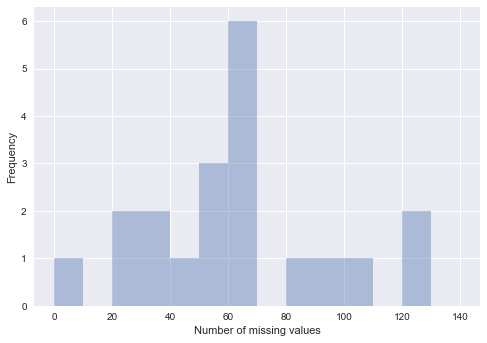

In [6]:
# Investigate missing values
missing_value_dict = {}
for col in df.columns:
    missing_value_dict[col] = sum(df[col].isnull())
print("Feature | Number of missing values")
pprint.pprint(sorted(missing_value_dict.items(), key=lambda x: x[1], reverse=True))

sns.distplot(missing_value_dict.values(), bins=range(0, 150, 10), kde=False)
plt.xlabel('Number of missing values')
plt.ylabel('Frequency')
plt.show()

In some data analyses, a prevalance of missing values might have been a legitimate reason to remove a feature before implementing a learning algorithm. However, in this analysis, I knew that many persons of interest held positions at the top of the organization. Hence, features that might not have been relevant for an average employee (*e.g.*, director fees) might have been highly relevant to employees in upper management and consequently highly useful for the machine learning algorithm. Consequently, I did not remove any features based on missing values. In the above exploratory analysis, I represented missing values as 'nan's. However, when applying the learning algorithm, it made logical sense to represent the missing values as 0 USD or 0 counts. Code below provided by Udacity made this transformation during the data import process for machine learning.

## Initial feature selection

I did remove one feature at this stage - email address. I believed that the the email address of each individual was unlikely to contain any information relevant for machine learning. This feature was essentially a unique string identifier for each data point, and basically a redundant index. 

In [7]:
# Task 1: Select what features you'll use.
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".

feature_list = [
    'poi',  
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    #'email_address',
    'exercised_stock_options',
    'expenses',
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'shared_receipt_with_poi',
    'to_messages',
    'total_payments',
    'total_stock_value'
]  

## Outlier removal

Based on the "Outliers" lesson from Udacity's "Intro to Machine Learning" course, I knew that the data contained one outlier that needed to be removed - a data point corresponding to the cumulative total for each features. I did not remove any other outliers from the data because in this particular machine learning exercise, I was purposefully trying to identify individuals that could be seen as anomalies. In all likelihood, many of the outliers probably provided the most useful information for the algorithm.

In [8]:
# Task 2: Remove outliers
del(data_dict['TOTAL'])

## Creation of new features

I created two new features from the supplied data. The first, 'ratio_poi_from_messages', was the number of emails sent from persons of interest to an individual normalized by the total number of emails the individual received. I reasoned that if a person received a high volume of emails in general (*e.g.*, an administrative assistant), then that person might also have a high count of emails from poi's by coincidence. The fraction of emails from poi might be a better indicator of affiliation with a poi. Likewise, I normalized the number of emails each individual sent to poi's by the total number of emails sent ('ratio_poi_to_messages').

In [9]:
# Task 3: Create new feature(s)
for key in data_dict.keys():
    if (data_dict[key]['from_poi_to_this_person'] == 'NaN') or \
       (data_dict[key]['from_messages'] == 'NaN'):
        data_dict[key]['ratio_poi_from_messages'] = 'NaN'
    else:
        data_dict[key]['ratio_poi_from_messages'] = \
        data_dict[key]['from_poi_to_this_person'] / \
        data_dict[key]['from_messages']
    if (data_dict[key]['from_this_person_to_poi'] == 'NaN') or \
       (data_dict[key]['to_messages'] == 'NaN'):
        data_dict[key]['ratio_poi_to_messages'] = 'NaN'
    else:
        data_dict[key]['ratio_poi_to_messages'] = \
        data_dict[key]['from_this_person_to_poi'] / \
        data_dict[key]['to_messages']
feature_list.append('ratio_poi_from_messages')
feature_list.append('ratio_poi_to_messages')

## Selection of Learning Algorithm

In this section, I applied multiple learning algorithms to the data with the ultimate goal of achieving greater than 0.3 precision and recall for the 'poi' class. Early on, it became clear that one of the most critical aspects of the exercise was to choose an appropriate validation strategy. After rectifying the validation method, finding the appropriate learning algorithm became simpler.

### Initial validation method

Validation is the process of assessing how well a learning algorithm will perform. One classic mistake would be to train the learner on all the data available, and then to test the model on the same data. This approach would provide an overly optimistic estimate of the learner's abilities. A less-biased approach for validation is to split the data into separate training and test sets. The learner is trained on the training data, and then evaluated on data it has never seen. Initially, I adopted this simple train/test split strategy to validate the learning algorithms. Following Udacity's code, I split off 30% of the data for testing, and used the remaining 70% for training.

In [10]:
# Extract features and labels from dataset for local testing
dataset = featureFormat(data_dict, feature_list, sort_keys=True)
labels, features = targetFeatureSplit(dataset)

# Initial test/train split validation method
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

### Algorithm 1: Decision Trees 

The first algorithm I used was a simple decision tree. Decision trees have the advantage of yielding results that can be human interpretable, and they do not necessarily require feature scaling. I used sklearn's default parameters, except for the 'class_weight' parameter. Knowing that the classes were inherently unbalanced, I asked the algorithm to balance the weights in the training set such that 'poi' instances would have equal influence in the training.

In [11]:
# Set up learning algorithm
clf = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best',
    max_depth=None, 
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features= 'sqrt',
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight='balanced',
    presort=False
)

# Train algorithm
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)

The two evaluation metrics of interest were the precision and recall of the test set. Precision is the fraction of true positives out of all cases classified positive, _i.e._:

$$\text{precision} = \frac{\text{true positives}}{\text{true positives} + \text{false positives}}$$

Recall is the fraction of true positives out of all factually positive cases, _i.e._:

$$\text{precision} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$$

The classification report I used also output the F1 scoring metric, which output a harmonic average of both precision and recall:

$${\displaystyle F_{1}=2\cdot {\frac {1}{{\tfrac {1}{\mathrm {precision} }}+{\tfrac {1}{\mathrm {recall} }}}}=2\cdot {\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}}$$

In [12]:
# Run report
print(classification_report(labels_test, pred, target_names=['non-poi', 'poi']))

             precision    recall  f1-score   support

    non-poi       0.90      0.97      0.94        39
        poi       0.50      0.20      0.29         5

avg / total       0.86      0.89      0.86        44



The initial algorithm training managed to accomplish a precision of 0.50 and a recall of 0.20, which seemed optimistic. However, after experimentng with the code some more, I observed that the random state I assigned to the splitting code could drastically alter the outcome of the validation step.  

In [13]:
# Try three different splits on the data, train the algorithm, and output results
for i in range(3, 6):
    features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=i)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    print('Test/train random state: {}'.format(i))
    print(classification_report(labels_test, pred, target_names=['non-poi', 'poi']))

Test/train random state: 3
             precision    recall  f1-score   support

    non-poi       0.89      0.92      0.91        37
        poi       0.50      0.43      0.46         7

avg / total       0.83      0.84      0.84        44

Test/train random state: 4
             precision    recall  f1-score   support

    non-poi       0.78      0.82      0.80        34
        poi       0.25      0.20      0.22        10

avg / total       0.66      0.68      0.67        44

Test/train random state: 5
             precision    recall  f1-score   support

    non-poi       0.83      0.92      0.87        37
        poi       0.00      0.00      0.00         7

avg / total       0.70      0.77      0.73        44



One random state could lead to a value of over 0.4 for both precision and recall for the poi class, while another could lead to a value of 0.0 for both. The variability in the results was probably due to several 

### Updated validation method

I investigated other approaches in sklearn's user documentation, and I also inspected the validation code in Udacity's tester.py file. Initially, I attempted to bundle the core of Udacity's code into a custom validation method. However, the code was overly slow, perhaps given the number of loops it utilized. I decided to use sklearn's Repeated Stratified K-fold cross-validation class. Ultimately, this validation scheme emulated many of the key attributes of Udacity's code. It (i) stratified the data, assuring that a balanced number of non-poi and poi data points were in both the training and testing subsets, (ii) performed a k-fold cross-validation, which averaged error estimation over k number of validation trials, and (iii) allowed me to further average the results over a given number of cross-validation repeats, thus improving the robustness of the precision and recall estimates. I chose to do 10-fold cross-validation, in line with Udacity's testing code, and I used 100 repeats to balance robustness with processing time.

In [14]:
# Define validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=42)

In tandem, I also adjusted my code so that I could test several combinations of parameters in my learning algorithm using a grid search. SkLearn's GridSearchCV algorithm requires a scoring dictionary to define the metrics for output. I instantiated precision and recall scoring methods, purposefully setting the 'average' parameter to 'binary' such that the scorers only considered the positively labelled class, _i.e._, the poi class. The grid search cross-validation approach only uses only a single metric to find optimal hyperparameters, however, so I also instantiated an F1 scoring method.

In [15]:
# Scoring metrics
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

I re-instantiated the decision tree algorithm, and I decided to tune the 'max_depth' and 'max_features' parameters. I purposefully interrogated small values for both of these parameters, knowing that decision trees have a tendency to overfit if they are allowed to grow excessively or if they are allowed to use too many features.

In [16]:
tree = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best',
    max_depth=None, 
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features= 'sqrt',
    random_state=42,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight='balanced',
    presort=False
)

# Set hyperparameter tuning space
param_grid = [
    {
        'max_depth': range(2, 5),
        'max_features': range(3, 6),
    }
]

# Perform grid search optimization
clf = GridSearchCV(tree, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='f1')
clf.fit(features, labels)

# Output results for best algorithm hyperparameters
print("Best parameters {}".format(clf.best_params_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("F1 score {:.2}".format(clf.best_score_))

/Users/joshuatice/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/joshuatice/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters {'max_features': 4, 'max_depth': 3}
Precision: 0.383802827381
Recall: 0.599930555556
F1 score 0.44


The outcome appeared to be successful when the number of features was set to 4 and the maximum depth of the tree was 3. To check against Udacity's standard, I ran the test_classifier method provided by Udacity with my optimized learner.

In [17]:
test_classifier(clf.best_estimator_, data_dict, feature_list=feature_list, folds = 1000)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3,
            max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
	Accuracy: 0.81687	Precision: 0.38525	Recall: 0.62700	F1: 0.47726	F2: 0.55709
	Total predictions: 15000	True positives: 1254	False positives: 2001	False negatives:  746	True negatives: 10999



Udacity's cross-validation yielded a result similar to my cross-validation output, with both precision and recall of the poi class above 0.3.  
Decision trees are sometimes relatively weak learners, and are sensitive to factors such as the initial state of the data or the initial features used in the tree splitting. I wanted to see if it was possible to increase the precision and recall even higher with an ensemble method.  

### Algorithm 1 continued: Decision Trees with Adaptive Boosting  

In an attmept to improve the performance of my decision tree algorithm, I used an adaptive boosting (adaboost) method to pool multiple learners into a stronger ensemble classifier. I used the same values of 'max_features' and 'max_depth' identified in the initial optimization performed above. Others have shown that the learning rate of the adaptive boosting algorithm ('learning_rate') and the number of estimators in the adaboost ensemble ('n_estimators') influence each other (Reference: [Trade-off between learning rate and number of learners](https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/)), so I tuned both of these parameters in the adaboost algorithm.

In [21]:
# Decision Trees with Adaptive Boosting (AdaBoost)

# Define classifier
boost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(
        criterion='gini', 
        splitter='best',
        max_depth=3, 
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features= 4,
        random_state=42,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_impurity_split=None,
        class_weight='balanced',
        presort=False
    ), 
    n_estimators=50, 
    learning_rate=1.0, 
    algorithm='SAMME.R', 
    random_state=42
)

# Set hyperparameter tuning space
param_grid = [
    {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.001, 0.01, 0.1, 0.3],
    }
]

# Perform grid search optimization
clf = GridSearchCV(boost, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='f1')
clf.fit(features, labels)

# Output results for best algorithm hyperparameters
print("Best parameters {}".format(clf.best_params_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("F1 score {:.2}".format(clf.best_score_))

KeyboardInterrupt: 

In [ ]:
test_classifier(clf.best_estimator_, data_dict, feature_list=feature_list, folds = 1000)

In [ ]:
# TESTING TESTING (SCALER -> FEATURE SELECTION -> SVC)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=42)

# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

#Optional: class weights
class_weight = {
    0: 1,
    1: 100
}

# Define pipeline components
scaler = MinMaxScaler()
feature_selection = SelectKBest(score_func=chi2)
classifier = SVC(
    C=1.0, 
    kernel='rbf', 
    degree=3, 
    gamma='auto', 
    coef0=0.0, 
    shrinking=True, 
    probability=False, 
    tol=0.001, 
    cache_size=200, 
    class_weight='balanced', 
    verbose=False, 
    max_iter=-1, 
    decision_function_shape='ovr', 
    random_state=42
)

# Define pipeline
pipe = Pipeline([
    ('scaler', scaler),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Tune classifier with grid search 
param_grid = [
    {
        'feature_selection__k': range(3, 10),
        'classifier__C': [10, 100, 1000]
    }
]

clf = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='f1')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("F1 score {:.2}".format(clf.best_score_))

In [ ]:
precision_scores = clf.cv_results_['mean_test_precision'].reshape(3, 7)
recall_scores = clf.cv_results_['mean_test_recall'].reshape(3, 7)

for i in range(3):
    plt.plot(range(3, 10), precision_scores[i], label='Precision')
    plt.plot(range(3, 10), recall_scores[i], label='Recall')
    plt.title("SVC C Parameter: {}".format(10**(i+1)), fontsize=16)
    plt.xlabel("Number of features")
    plt.ylabel("Scores")
    plt.legend()
    plt.show()

In [ ]:
# Which features are helping the most

# Define pipeline elements
scaler = MinMaxScaler()
X = scaler.fit_transform(features)

for i in range(4, 7):
    feature_selection = SelectKBest(score_func=chi2, k=i)
    feature_selection.fit(X, labels)
    mask = feature_selection.get_support()
    ranks = dict(zip(np.array(feature_list)[1:][mask], feature_selection.scores_))
    print("Top features for k={}:".format(i))
    pprint.pprint(sorted(ranks.items(), key=lambda x: x[1], reverse=True))

In [ ]:
pprint.pprint(feature_list)

In [ ]:
feature_list_test = [
    'poi', 
    #'bonus', 
    'exercised_stock_options', 
    #'loan_advances', 
    'total_stock_value',
    'from_poi_to_this_person',
    'from_this_person_to_poi'
    #'ratio_poi_from_messages',
    #'ratio_poi_to_messages'
]
    
# Extract features and labels from dataset for local testing
dataset_test = featureFormat(data_dict, feature_list, sort_keys=True)
labels_test, features_test = targetFeatureSplit(dataset_test)

# Define pipeline
scaler = MinMaxScaler()
classifier = SVC(
    C=100, 
    kernel='rbf', 
    degree=3, 
    gamma='auto', 
    coef0=0.0, 
    shrinking=True, 
    probability=False, 
    tol=0.001, 
    cache_size=200, 
    class_weight='balanced', 
    verbose=False, 
    max_iter=-1, 
    decision_function_shape='ovr', 
    random_state=42
)

# Define pipeline
clf_test = Pipeline([
    ('scaler', scaler),
    ('classifier', classifier)
])

test_classifier(clf_test, data_dict, feature_list=feature_list_test, folds = 1000)

## Feature scaling

Some of the features in the dataset had drastically different ranges. For instance, the features that I created above were purposefully created on a scale of 0 to 1, while some of the provided financial features had values in the millions of dollars. While not all learning algorithms require feature scaling, some could have substantially biased by non-normalized data, such as SVM's or linear models. To make sure all the features had similar ranges, I applied a simple min/max scaler to the data. At this point, the data were transferred to a Numpy array to be compatible with SciKit-Learn's code.

In [ ]:
# Extract features and labels from dataset for local testing
dataset = featureFormat(data_dict, feature_list, sort_keys=True)
labels, features = targetFeatureSplit(dataset)

# Scale features 
#scaler = MinMaxScaler()
#features = scaler.fit_transform(features)

In [ ]:
# SELECT FEATURES !!!

In [ ]:
# TESTING TESTING (GRADIENT BOOST TUNE)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Define classifier
boost = GradientBoostingClassifier( 
    loss='deviance', 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample=1.0, 
    criterion='friedman_mse', 
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_depth=3, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    init=None, 
    random_state=42, 
    max_features=None, 
    verbose=0, 
    max_leaf_nodes=None, 
    warm_start=False, 
    presort='auto'
)

# Tune classifier with grid search 
# Ref: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
param_grid = [
    {
        #'n_estimators': [],
        'learning_rate': [0.001, 0.01, 0.1],
    }
]
clf = GridSearchCV(boost, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='recall')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Best f1 score {:.2}".format(clf.best_score_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("Precision / Recall")
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

In [ ]:
# TESTING TESTING (LOGISITIC REGRESSION)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

class_weight = {
    0: 1,
    1: 1000
}
# Define classifier
lm = LogisticRegression(
    penalty='l2', 
    dual=False, 
    tol=0.0001, 
    C=1.0, 
    fit_intercept=True, 
    intercept_scaling=1, 
    class_weight=class_weight, 
    random_state=42, 
    solver='liblinear', 
    max_iter=100, 
    multi_class='ovr', 
    verbose=0, 
    warm_start=False, 
    n_jobs=1
)

# Tune classifier with grid search 
# Ref: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
param_grid = [
    {
        'C': [1, 10, 100, 500, 1000], 
    }
]
clf = GridSearchCV(lm, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='precision')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Best f1 score {:.2}".format(clf.best_score_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("Precision / Recall")
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

In [ ]:
clf_test = clf.best_estimator_
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 100)

In [ ]:
clf_test = clf.best_estimator_
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

In [ ]:
# TESTING TESTING (SUPPORT VECTOR MACHINE)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)

# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Class weights
class_weight = {
    0: 1,
    1: 1000
}

# Define classifier
svc = SVC(
    C=1.0, 
    kernel='rbf', 
    degree=3, 
    gamma='auto', 
    coef0=0.0, 
    shrinking=True, 
    probability=False, 
    tol=0.001, 
    cache_size=200, 
    class_weight=class_weight, 
    verbose=False, 
    max_iter=-1, 
    decision_function_shape='ovr', 
    random_state=42
)

# Tune classifier with grid search 
# Ref: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
param_grid = [
    {
        'C': [1, 10, 100, 500, 1000], 
    }
]
clf = GridSearchCV(svc, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='f1')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
print("Best f1 score {:.2}".format(clf.best_score_))
print("Precision: {}".format(clf.cv_results_['mean_test_precision'][clf.best_index_]))
print("Recall: {}".format(clf.cv_results_['mean_test_recall'][clf.best_index_]))
print("Precision / Recall")
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

In [ ]:
clf_test = clf.best_estimator_
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

In [ ]:
clf_test = clf.best_estimator_
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

In [ ]:
clf_test = pipe
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

In [ ]:
# TESTING TESTING (SCALER -> FEATURE SELECTION -> LOGISTIC REGRESSION)

# Define validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=42)
# Scoring methods
precision_scorer = make_scorer(precision_score, average='binary', pos_label=1)
recall_scorer = make_scorer(recall_score, average='binary', pos_label=1)
f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)
scoring_dict = {
    'precision': precision_scorer,
    'recall': recall_scorer,
    'f1': f1_scorer
}

# Define pipeline
scaler = MinMaxScaler()
feature_selection = SelectKBest(score_func=chi2)
classifier = LogisticRegression(
    penalty='l2', 
    dual=False, 
    tol=0.0001, 
    C=1.0, 
    fit_intercept=True, 
    intercept_scaling=1, 
    class_weight='balanced', 
    random_state=42, 
    solver='liblinear', 
    max_iter=100, 
    multi_class='ovr', 
    verbose=0, 
    warm_start=False, 
    n_jobs=1
)

# Define pipeline
pipe = Pipeline([
    ('scaler', scaler),
    ('feature_selection', feature_selection),
    ('classifier', classifier)
])

# Tune classifier with grid search 
param_grid = [
    {
        'feature_selection__k': range(3, 10),
        'classifier__C': [1],
        'classifier__class_weight': [{0:1, 1:10}, {0:1, 1:20}, {0:1, 1:50}]        
    }
]

clf = GridSearchCV(pipe, param_grid=param_grid, scoring=scoring_dict, cv=cv, refit='precision')
clf.fit(features, labels)
print("Best parameters {}".format(clf.best_params_))
pprint.pprint(zip(clf.cv_results_['mean_test_precision'], clf.cv_results_['mean_test_recall']))

In [ ]:
clf_test = pipe
test_classifier(clf_test, data_dict, feature_list=feature_list, folds = 1000)

In [ ]:
# Perform additional features selection
feature_selection = SelectKBest(score_func=chi2, k=10)
feature_selection.fit(features, labels)
mask = feature_selection.get_support()
ranks = dict(zip(np.array(feature_list)[1:][mask], feature_selection.scores_))
pprint.pprint(sorted(ranks.items(), key=lambda x: x[1], reverse=True))
X = feature_selection.transform(features)
# Up sample features to account for class imbalance
upsampler = ADASYN(ratio='minority', random_state=42)
X, y = upsampler.fit_sample(X, labels)

## Validation strategy

If the learning algorithm was trained on the entire dataset, then the likelihood of overfitting would have been exacerbated. I would have no way of assessing the effecivenes of the learning algorithm when presented with previously unseen data. Hence, after scaling all of the data, I split the data into a training set and a test set for validation purposes. 

In [ ]:
# Perform additional features selection
feature_selection = SelectKBest(score_func=chi2, k=10)
feature_selection.fit(X_train, y_train)
mask = feature_selection.get_support()
ranks = dict(zip(np.array(feature_list)[1:][mask], feature_selection.scores_))
pprint.pprint(sorted(ranks.items(), key=lambda x: x[1], reverse=True))
X_train = feature_selection.transform(X_train)
X_test = feature_selection.transform(X_test)

# Up sample features to account for class imbalance
upsampler = ADASYN(ratio='minority', random_state=42)
X_train, y_train = upsampler.fit_sample(X_train, y_train)

In [ ]:
# Task 4: Try a varity of classifiers
# Please name your classifier clf for easy export below.
# Note that if you want to do PCA or other multi-stage operations,
# you'll need to use Pipelines. For more info:
# http://scikit-learn.org/stable/modules/pipeline.html

# Create first classifier
clf = SVC(C=1, random_state=42)
clf.fit(X_train, y_train)

# Test first classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['non-poi', 'poi']))

In [ ]:




# Task 5: Tune your classifier to achieve better than .3 precision and recall
# using our testing script. Check the tester.py script in the final project
# folder for details on the evaluation method, especially the test_classifier
# function. Because of the small size of the dataset, the script uses
# stratified shuffle split cross validation. For more info:
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

test_classifier(clf, data_dict, feature_list, folds = 1000)

# Task 6: Dump your classifier, dataset, and features_list so anyone can
# check your results. You do not need to change anything below, but make sure
# that the version of poi_id.py that you submit can be run on its own and
# generates the necessary .pkl files for validating your results.

# dump_classifier_and_data(clf, my_dataset, features_list)


if __name__ == '__main__':
    pass
    #test_multiple(classifier_types, features_train, features_test, labels_train,
    #labels_test)


